In [205]:
import pandas as pd
df = pd.read_csv('housing.csv',header=None, sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', \
'NOX', 'RM', 'AGE', 'DIS', 'RAD',
'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [206]:
X_t2 = np.array([X.reshape(506),z,ind,cri,nox,age/10,dis,ptr,lst_std])
X_t2 = X_t2.T

In [207]:
import numpy as np
X = df[['RM']].values
y = df['MEDV'].values
z = df['RAD'].values
zn = df['ZN'].values
ind = df['INDUS'].values
cri = df['CRIM'].values
nox = df['NOX'].values
age = df['AGE'].values
dis = df['DIS'].values
tax = df['TAX'].values
ptr = df['PTRATIO'].values
bb = df['B'].values
lst = df['LSTAT'].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
sc_z = StandardScaler()
sc_zn = StandardScaler()
sc_ind = StandardScaler()
sc_cri = StandardScaler()
sc_nox = StandardScaler()
sc_age = StandardScaler()
sc_dis = StandardScaler()
sc_tax = StandardScaler()
sc_ptr = StandardScaler()
sc_bb = StandardScaler()
sc_lst = StandardScaler()


In [208]:
X_std = sc_x.fit_transform(X)
y_std = y/10
z_std = sc_z.fit_transform(z[:, np.newaxis]).flatten()
zn_std = sc_zn.fit_transform(zn[:, np.newaxis]).flatten()
ind_std = sc_ind.fit_transform(ind[:, np.newaxis]).flatten()
cri_std = sc_cri.fit_transform(cri[:, np.newaxis]).flatten()
nox_std = sc_nox.fit_transform(nox[:, np.newaxis]).flatten()
age_std = sc_age.fit_transform(age[:, np.newaxis]).flatten()
dis_std = sc_dis.fit_transform(dis[:, np.newaxis]).flatten()
tax_std = sc_tax.fit_transform(tax[:, np.newaxis]).flatten()
ptr_std = sc_ptr.fit_transform(ptr[:, np.newaxis]).flatten()
bb_std = sc_bb.fit_transform(bb[:, np.newaxis]).flatten()
lst_std = sc_lst.fit_transform(lst[:, np.newaxis]).flatten()

In [209]:
X_t = np.array([X_std.reshape(506),z_std,zn_std,ind_std,cri_std,nox_std,age_std,dis_std,tax_std,ptr_std,bb_std,lst_std])
X_t = X_t.T

In [210]:
import numpy as np
import sys
class NeuralNetMLP(object):
  def __init__(self, n_hidden=30, l2=0., epochs=100, eta=0.001, shuffle=True,minibatch_size=1, seed=None):
    self.random = np.random.RandomState(seed)
    self.n_hidden = n_hidden
    self.l2 = l2
    self.epochs = epochs
    self.eta = eta
    self.shuffle = shuffle
    self.minibatch_size = minibatch_size
  def _onehot(self, y, n_classes):
    """Encode labels into one-hot representation
    Parameters
    ------------
    y : array, shape = [n_samples]
    Target values.
    Returns
    -----------
    onehot : array, shape = (n_samples, n_labels)
    """
    onehot = np.zeros((n_classes, y.shape[0]))
    for idx, val in enumerate(y.astype(int)):
      onehot[val, idx] = 1.
    return onehot.T
  def _sigmoid(self, z):
    """Compute logistic function (sigmoid)"""
    return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
  def _reLU(self,x):
    x = np.maximum(0, x)
    return x
  def _dropout(self, X):
    a = np.random.randint(2, size=X.shape)
    while np.array_equal(a,np.zeros(shape=X.shape)):
      a = np.random.randint(2, size=X.shape)
    return X*a
  def _forward(self, X):
    """Compute forward propagation step"""
    # step 1: net input of hidden layer
    # [n_samples, n_features] dot [n_features, n_hidden]
    # -> [n_samples, n_hidden]
    X = self._dropout(X)
    z_h = np.dot(X, self.w_h) + self.b_h
    # step 2: activation of hidden layer
    a_h = self._reLU(z_h)
    # step 3: net input of output layer
    # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
    # -> [n_samples, n_classlabels]
    z_out = np.dot(a_h, self.w_out) + self.b_out
    # step 4: activation output layer
    a_out = self._reLU(z_out)
    return z_h, a_h, z_out, a_out
  def _compute_cost(self, y_enc, output):
    """Compute cost function.
    Parameters
    ----------
    y_enc : array, shape = (n_samples, n_labels)
    one-hot encoded class labels.
    output : array, shape = [n_samples, n_output_units]
    Activation of the output layer (forward propagation)
    Returns
    ---------
    cost : float
    Regularized cost
    """
    L2_term = (self.l2 *(np.sum(self.w_h * 2.)+np.sum(self.w_out ** 2.)))
    cost = np.sum((y_enc - output.reshape(400))**2) + L2_term
    return cost
  def predict(self, X):
    """Predict class labels
    Parameters
    -----------
    X : array, shape = [n_samples, n_features]
    Input layer with original features.
    Returns:
    ----------
    y_pred : array, shape = [n_samples]
    Predicted class labels.
    """
    z_h, a_h, z_out, a_out = self._forward(X)
    return a_out
  def fit(self, X_train, y_train, X_valid, y_valid):
      """ Learn weights from training data.
      Parameters
      -----------
      X_train : array, shape = [n_samples, n_features]
      Input layer with original features.
      y_train : array, shape = [n_samples]
      Target class labels.
      X_valid : array, shape = [n_samples, n_features]
      Sample features for validation during training
      y_valid : array, shape = [n_samples]
      Sample labels for validation during training
      Returns:
      ----------
      self
      """
      n_output = 1 # no. of class labels
      n_features = X_train.shape[1]
      ########################
      # Weight initialization
      ########################
      # weights for input -> hidden
      self.b_h = np.zeros(self.n_hidden)
      self.w_h = self.random.normal(loc=0.0, scale=0.1, size=(n_features, self.n_hidden))

      # weights for hidden -> output
      self.b_out = np.zeros(n_output)
      self.w_out = self.random.normal(loc=0.0, scale=0.1,
      size=(self.n_hidden, n_output))
      epoch_strlen = len(str(self.epochs)) # for progr. format.
      self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
      y_train_enc = y_train
      #print(y_train_enc.shape)
      # iterate over training epochs
      for i in range(self.epochs):
        #print(i)
        # iterate over minibatches
        indices = np.arange(X_train.shape[0])

        if self.shuffle:
          self.random.shuffle(indices)
        for start_idx in range(0,indices.shape[0] -self.minibatch_size +1,self.minibatch_size):
          batch_idx = indices[start_idx:start_idx+self.minibatch_size]
          # forward propagation
          #X_train[batch_idx] = self._dropout(X_train[batch_idx])
          z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])
          ##################
          # Backpropagation
          ##################
          # [n_samples, n_classlabels]
          sigma_out = a_out - y_train_enc[batch_idx]
          # [n_samples, n_hidden]
          sigmoid_derivative_h = a_h
          for i in range(len(a_h[0])):
            if a_h[0][i] >0:
              sigmoid_derivative_h[0][i] = 1
            else:
              sigmoid_derivative_h[0][i] = 0          
          # [n_samples, n_classlabels] dot
          # [n_classlabels, # n_hidden]
          # -> [n_samples, n_hidden]
          sigma_h = (np.dot(sigma_out, self.w_out.T)*sigmoid_derivative_h)
          #print(X_train[batch_idx].T.shape)
          #print(np.dot(sigma_out, self.w_out.T).shape)
          # [n_features, n_samples] dot [n_samples, n_hidden]
          # -> [n_features, n_hidden]
          grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
          grad_b_h = np.sum(sigma_h, axis=0)
          # [n_hidden, n_samples] dot [n_samples, n_classlabels]
          # -> [n_hidden, n_classlabels]
          grad_w_out = np.dot(a_h.T, sigma_out)
          grad_b_out = np.sum(sigma_out, axis=0)
          # Regularization and weight updates
          delta_w_h = (grad_w_h + self.l2*self.w_h)
          delta_b_h = grad_b_h # bias is not regularized
          self.w_h -= self.eta * delta_w_h
          self.b_h -= self.eta * delta_b_h
          delta_w_out = (grad_w_out + self.l2*self.w_out)
          delta_b_out = grad_b_out # bias is not regularized
          self.w_out -= self.eta * delta_w_out
          self.b_out -= self.eta * delta_b_out
          #############
          # Evaluation
          #############
          # Evaluation after each epoch during training
        z_h, a_h, z_out, a_out = self._forward(X_train)
        cost = self._compute_cost(y_train_enc,a_out)
        y_train_pred = self.predict(X_train)
        y_valid_pred = self.predict(X_valid)
        train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float)/X_train.shape[0])
        valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float)/X_valid.shape[0])
        self.eval_['cost'].append(cost)
        self.eval_['train_acc'].append(train_acc)
        self.eval_['valid_acc'].append(valid_acc)
      return self
nn = NeuralNetMLP()
nn.fit(X_train=X_t[:400],\
y_train=y_std[:400],\
X_valid=X_t[400:],\
y_valid=y_std[400:])
#>>> 200/200 | Cost: 5065.78 | Train/Valid Acc.: 99.28%/97.98%


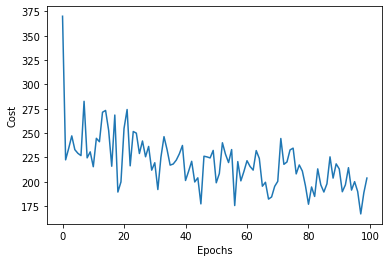

In [211]:
import matplotlib.pyplot as plt
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

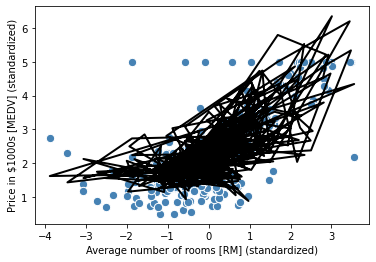

In [212]:
def lin_regplot(X, y, model):
  plt.scatter(X.T[0], y, c='steelblue', edgecolor='white', s=70)
  plt.plot(X.T[0], model.predict(X), color='black', lw=2)
  return None
lin_regplot(X_t, y_std, nn)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')
plt.show()

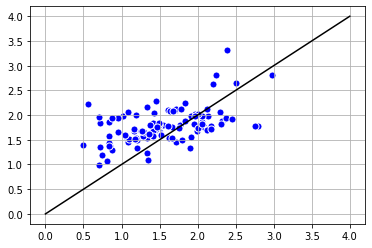

In [213]:
x = np.linspace(0,4,100)
plt.scatter(y_std[400:], nn.predict(X_t[400:]), c='b',edgecolor='white',s=50)
plt.plot(x,x,c='black')
plt.grid()